# NLP - Disaster Tweets - BERT

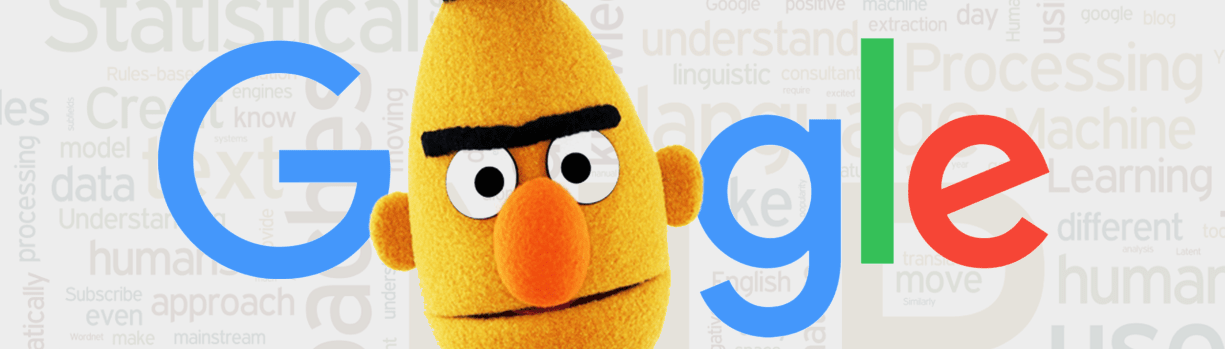

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
#stop words import
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df =  pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Exploratory Analysis

In [4]:
#removing duplicates
print(len(train_df))
train_df = train_df.drop_duplicates('text', keep='last')
print(len(train_df))

In [5]:
train_df.head(10)

In [6]:
test_df.head()

In [7]:
#count plot
sns.countplot(train_df['target'])
print(train_df['target'].value_counts())

In [8]:
plt.figure(figsize=(15,100))
sns.countplot(data=train_df, y='keyword', hue='target')
plt.title('Target Distribution in Keywords')
plt.show()

## Feature Engineering

Disaster tweets are generally longer in length are more formal in nature and so people tend to include less typos, are more formal with longer words and include more punctuation. Addittionally more official sources such as news agencies tend to report on disasters and may include twitter @'s and hashtags to boost traction. Some may additionally link to articles via URLs. We will also utilise 'stop words', commonly used in NLP to eliminate words that are so commonly used that they carry very little value.
We can therefore utilise feature engineering to extract additional features from the 'text' total.

In [9]:
#word count
def wordCount(x):
    return len(x.split())

train_df['word_count'] = train_df['text'].apply(wordCount)
test_df['word_count'] = test_df['text'].apply(wordCount)

In [10]:
#unique word count
def uniqueWordCount(tweet):
    return len(set(tweet.split()))

train_df['unique_word_count'] = train_df['text'].apply(uniqueWordCount)
test_df['unique_word_count'] = test_df['text'].apply(uniqueWordCount)

In [11]:
#stop word count
stopwords = nltk.corpus.stopwords.words('english')
def stopWordCount(tweet):
    tweet = tweet.lower()
    tweet = tweet.split()
    countStopWords = 0
    for w in tweet:
        if w in stopwords:
            countStopWords += 1

    return countStopWords

train_df['stop_word_count'] = train_df['text'].apply(stopWordCount)
test_df['stop_word_count'] = test_df['text'].apply(stopWordCount)

In [12]:
#mean word length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in (x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in (x).split()]))

In [13]:
#character count
charCount = lambda x: len(x)
train_df['char_count'] = train_df['text'].apply(charCount)
test_df['char_count'] = test_df['text'].apply(charCount)

In [14]:
#punctuation count
import string

def punctuationCount(tweet):
    countPunctuation = 0
    for punc in list(string.punctuation):
        countPunctuation += tweet.count(punc)
    
    return countPunctuation

train_df['punctuation_count'] = train_df['text'].apply(punctuationCount)
test_df['punctuation_count'] = test_df['text'].apply(punctuationCount)

In [15]:
#mention count
def mentionCount(x):
    return x.count('@')

train_df['mention_count'] = train_df['text'].apply(mentionCount)
test_df['mention_count'] = test_df['text'].apply(mentionCount)

In [16]:
#hashtag count
def hashtagCount(tweet):
    return tweet.count('#')

train_df['hashtag_count'] = train_df['text'].apply(hashtagCount)
test_df['hashtag_count'] = test_df['text'].apply(hashtagCount)

In [17]:
Eng_features = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 'punctuation_count', 'mention_count', 'hashtag_count']
Disaster_tweets = train_df['target']==1

fig, axes = plt.subplots(ncols=2, nrows=len(Eng_features), figsize=(20, 50), dpi=100)

for i, feature in enumerate(Eng_features):
    sns.histplot(train_df.loc[~Disaster_tweets][feature], label='Not Disaster', ax=axes[i][0], color='blue', stat="density")
    sns.histplot(train_df.loc[Disaster_tweets][feature], label='Disaster', ax=axes[i][0], color='yellow', stat="density")

    sns.histplot(train_df[feature], label='Training', ax=axes[i][1], color='blue', stat="density")
    sns.histplot(test_df[feature], label='Test', ax=axes[i][1], color='red', stat="density")

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

Based on the distributions its likely that both training and test data come from the same original dataset / pool, therefore there is no real need in this case to perform an 80/20 validation during modelling, we can just train on the training set and then use it to predict our test.

## Pre-processing

In [18]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

In [19]:
import re

def preprocess_text(text):
    text = re.sub(urlPattern,'URL',text)
    for c in string.punctuation:
        text=text.replace(c,"")
    return text

train_df['text'] = train_df['text'].apply(preprocess_text) 
test_df ['text'] = test_df['text'].apply(preprocess_text)

print(string.punctuation)

In [20]:
def remove_punctuation(text):
    text_nopunc= "".join([c for c in text if c not in string.punctuation])
    return text_nopunc

In [21]:
train_df['text_clean'] = train_df['text'].apply(lambda x: remove_punctuation(x))
train_df.head()

In [22]:
import re
def tokenise(text):
    tokens = re.split('\W+', text)
    return tokens

train_df['text_clean'] = train_df['text_clean'].apply(lambda x: tokenise(x.lower()))
train_df.head(2)

In [23]:
stopwords[0:10]
def remove_stopwords(text_tokenised):
    text_clean = [word for word in text_tokenised if word not in stopwords]
    return text_clean

train_df['text_clean'] = train_df['text_clean'].apply(lambda x: remove_stopwords(x))
train_df.head(5)

In [24]:
#Lemmatization
#Lemmatization is typically more accurate than stemming but also more computationally expensive, so understanding this tradeoff is important.

In [25]:
import nltk
#nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatization(token_txt):
    text = " ".join([wn.lemmatize(word) for word in token_txt])
    return text

train_df['text_clean'] = train_df['text_clean'].apply(lambda x : lemmatization(x))
train_df.head(2)

# BERT Encoding (Vectorisation).

In [26]:
!pip3 install tensorflow_text

In [27]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [28]:
#Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural network layers
layer = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(layer)

#Construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[layer])

In [29]:
model.summary()

In [30]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics = METRICS)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['target'], stratify=train_df['target'])

In [32]:
X_train.head(5)

In [33]:
history = model.fit(X_train, y_train, epochs=20)

In [ ]:
predictions = model.predict(test_df['text'])
preds = np.where(predictions > 0.5, 1, 0)
print(preds)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
submission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission["target"]=preds
submission.to_csv('submission.csv', index=False, header=True)